In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
with open("example.txt", "r") as file:
    content = file.read()


In [3]:
examples = content.strip().split("Example:")

In [4]:
post_data = []
comment_data = []

In [5]:
for i in range(1, 11):
    post_data.append(examples[i].strip().split('\n\n')[0])
    comment_data.append(examples[i].split('\n\n')[1])
    comment_data.append(examples[i].split('\n\n')[2])
    comment_data.append(examples[i].split('\n\n')[3])
    

In [6]:
post_columns = ["Post ID", "Title", "Content", "Timestamp", "Author ID", "Upvote Ratio", "Number of Comments", "Post Type"]
comment_columns = ["Comment ID", "Post ID", "Content", "Timestamp", "Author ID", "Upvotes"]

post_df = pd.DataFrame([post.split('\n') for post in post_data], columns=post_columns)
comment_df = pd.DataFrame([comment.split('\n') for comment in comment_data], columns=comment_columns)

In [7]:
print("Posts DataFrame:")
print(post_df[:5])
print("\nComments DataFrame:")
print(comment_df[:5])

Posts DataFrame:
  Post ID                                     Title  \
0   p1xrp               Ripple's Recent Price Surge   
1   p2xrp  Technical Analysis of XRP Price Movement   
2   p3xrp            XRP Adoption Continues to Grow   
3   p4xrp  Regulatory Developments Impact XRP Price   
4   p5xrp        XRP Community Celebrates Milestone   

                                             Content            Timestamp  \
0  Ripple (XRP) has experienced a significant pri...  2023-08-15 09:30:00   
1  Analyzing the technical indicators, it seems t...  2023-08-15 14:15:00   
2  More businesses are integrating XRP as a payme...  2023-08-16 11:00:00   
3  Recent regulatory announcements have caused fl...  2023-08-17 16:45:00   
4  The XRP community has reached a milestone of 1...  2023-08-18 08:00:00   

             Author ID Upvote Ratio Number of Comments    Post Type  
0      cryptoTrader123         0.92                 25   News        
1          TAexpert456         0.85              

In [21]:
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [22]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [27]:
def polarity_scores_finbert(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'finbert_neg' : scores[0],
        'finbert_neu' : scores[1],
        'finbert_pos' : scores[2]
    }
    return scores_dict

In [28]:
res = {}
for i, row in comment_df.iterrows():
    text = row['Content']
    myid = row['Comment ID']
    res[myid] = polarity_scores_finbert(text)

In [33]:
finberts = pd.DataFrame(res).T
finberts = finberts.reset_index().rename(columns={'index': 'Comment ID'})
finberts = finberts.merge(comment_df, how='left')

In [34]:
finberts.head()

,Comment ID,finbert_neg,finbert_neu,finbert_pos,Post ID,Content,Timestamp,Author ID,Upvotes
0,c1_1xrp,0.041659,0.050087,0.908254,p1xrp,This price surge is incredible! Is this relate...,2023-08-15 10:05:00,curiousTrader42,8
1,c1_2xrp,0.577915,0.031017,0.391069,p1xrp,I think the entire crypto market is experienci...,2023-08-15 11:20:00,cryptoHodlerXYZ,12
2,c1_3xrp,0.240741,0.017783,0.741476,p1xrp,"The price movement has been impressive, but it...",2023-08-15 12:45:00,cautiousInvestor,6
3,c2_1xrp,0.081051,0.370209,0.548740,p2xrp,"Your analysis seems solid, but I wonder how ex...",2023-08-15 15:00:00,analyticalMind,10
4,c2_2xrp,0.560845,0.010708,0.428448,p2xrp,I appreciate the technical insights. This coul...,2023-08-15 16:30:00,tradingEnthusiast,7


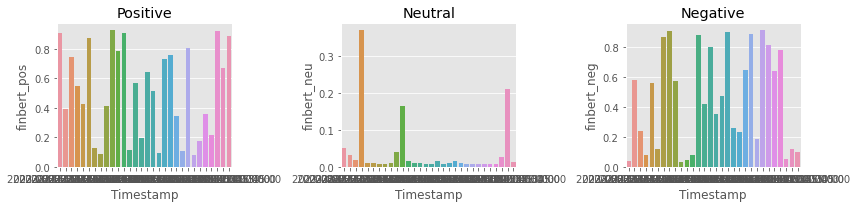

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=finberts, x='Timestamp', y='finbert_pos', ax=axs[0])
sns.barplot(data=finberts, x='Timestamp', y='finbert_neu', ax=axs[1])
sns.barplot(data=finberts, x='Timestamp', y='finbert_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [44]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [49]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in comment_df.iterrows():
    try:
        text = row['Content']
        myid = row['Coment ID']
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')